In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import torch.nn.functional as F

import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [ ]:
class WineDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {'Red': 0, 'White': 1, 'Rose': 2, 'Specialty': 3, 'Sparkling': 4, 'Sake_Rice_wine' : 5, 'Icewine': 6, 'Fortified': 7, 'Dessert': 8, 'Champagne': 9}
        self.idx_to_class = {0: 'Red', 1: 'White', 2: 'Rose', 3: 'Specialty', 4: 'Sparkling', 5: 'Sake_Rice_wine', 6: 'Icewine', 7: 'Fortified', 8: 'Dessert', 9: 'Champagne'}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, str(self.dataframe.iloc[idx]['image_path']))
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.dataframe.iloc[idx]['Type']]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(excel_path, root_dir, img_size=128):
    df = pd.read_excel(excel_path)
    df.dropna(subset=['image_path'], inplace=True)

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Type'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Type'], random_state=42)

    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = WineDataset(train_df, root_dir, transform=train_transform)
    val_dataset = WineDataset(val_df, root_dir, transform=val_test_transform)
    test_dataset = WineDataset(test_df, root_dir, transform=val_test_transform)

    # Handle class imbalance with weighted sampling
    class_counts = train_df['Type'].value_counts().to_dict()
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[cls] for cls in train_df['Type']]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader, train_dataset.class_to_idx

In [4]:
class WineCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(WineCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.cpu())

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc.cpu())

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict().copy()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print('-' * 10)

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

In [6]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Preparing data...
Initializing model...
Training model...
Epoch 1/30
Train Loss: 1.9309 Acc: 0.2239
Val Loss: 1.9826 Acc: 0.0856
----------
Epoch 2/30
Train Loss: 1.3188 Acc: 0.3284
Val Loss: 1.9549 Acc: 0.1073
----------
Epoch 3/30
Train Loss: 1.2085 Acc: 0.3394
Val Loss: 1.5289 Acc: 0.1359
----------
Epoch 4/30
Train Loss: 1.1703 Acc: 0.3703
Val Loss: 1.6036 Acc: 0.1277
----------
Epoch 5/30
Train Loss: 1.0761 Acc: 0.3916
Val Loss: 1.5367 Acc: 0.1481
----------
Epoch 6/30
Train Loss: 0.9427 Acc: 0.4370
Val Loss: 1.5554 Acc: 0.1508
----------
Epoch 7/30
Train Loss: 0.9413 Acc: 0.4233
Val Loss: 1.4364 Acc: 0.1413
----------
Epoch 8/30
Train Loss: 0.8501 Acc: 0.4585
Val Loss: 1.4077 Acc: 0.1739
----------
Epoch 9/30
Train Loss: 0.8475 Acc: 0.4512
Val Loss: 1.3604 Acc: 0.1739
----------
Epoch 10/30
Train Loss: 0.7713 Acc: 0.4780
Val Loss: 1.5203 Acc: 0.1685
----------
Epoch 11/30
Train Loss: 0.7302 Acc: 0.4975
Val Loss: 1.3316 Acc: 0.1630
----------
Epoch 12/30
Train Loss: 0.7683 Acc: 0.

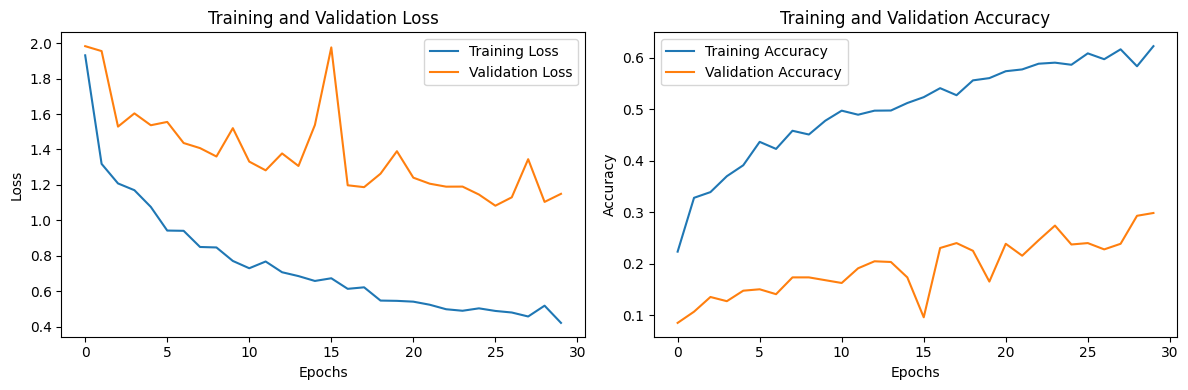

Evaluating model...
Test Accuracy: 0.2958

Classification Report:
                precision    recall  f1-score   support

           Red       1.00      0.02      0.04       273
         White       0.86      0.30      0.45       178
          Rose       0.75      0.64      0.69        61
     Specialty       0.12      0.29      0.17        21
     Sparkling       0.41      0.21      0.28        81
Sake_Rice_wine       0.40      0.71      0.51        51
       Icewine       0.13      0.71      0.22         7
     Fortified       0.14      0.80      0.24        25
       Dessert       0.09      0.81      0.16        16
     Champagne       0.20      0.96      0.33        24

      accuracy                           0.30       737
     macro avg       0.41      0.54      0.31       737
  weighted avg       0.73      0.30      0.27       737



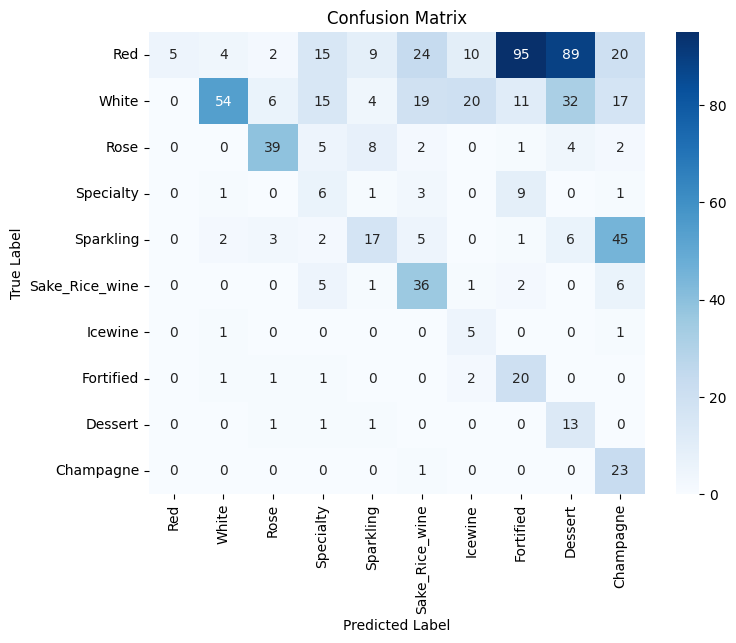

Model saved as wine_classifier.pth
Class mapping saved as class_to_idx.json


In [ ]:
def main():
    # Parameters
    excel_path = '/content/drive/MyDrive/Wine_Data/wine_data.xlsx' 
    root_dir = '/content/drive/MyDrive/Wine_Data/Data'   
    img_size = 128
    num_epochs = 30
    learning_rate = 0.001

    print("Preparing data...")
    train_loader, val_loader, test_loader, class_to_idx = prepare_data(excel_path, root_dir, img_size)

    print("Initializing model...")
    model = WineCNN(num_classes=len(class_to_idx))
    model = model.to(device)

    class_counts = pd.read_excel(excel_path)['Type'].value_counts()
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    print("Training model...")
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )

    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    print("Evaluating model...")
    all_preds, all_labels = evaluate_model(model, test_loader)

    test_acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

    class_names = list(class_to_idx.keys())
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    plot_confusion_matrix(all_labels, all_preds, class_names)

    torch.save(model.state_dict(), 'wine_classifier.pth')
    print("Model saved as wine_classifier.pth")

    with open('class_to_idx.json', 'w') as f:
        json.dump(class_to_idx, f)
    print("Class mapping saved as class_to_idx.json")

if __name__ == "__main__":
    main()